In [7]:
# ==============================================================================
# IMAGE CAPTION GENERATOR
# ==============================================================================
# This script builds a deep learning model to automatically generate captions
# for images using a CNN-LSTM (Encoder-Decoder) architecture.
#
# Tech Stack: Python, TensorFlow, Keras, Pillow
#
# To Run This Script:
# 1. Download the Flickr8k dataset.
#    - Images: https://www.kaggle.com/datasets/adityajn105/flickr8k
#    - Text (captions): The 'Flickr8k.token.txt' file is usually included.
# 2. Place the 'Flicker8k_Dataset' folder (containing images) and the
#    'Flickr8k.token.txt' file in the same directory as this script.
# 3. Run `pip install tensorflow numpy Pillow tqdm`
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. IMPORTING LIBRARIES
# ------------------------------------------------------------------------------
import os
import string
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tqdm import tqdm

print("Libraries imported successfully.")


Libraries imported successfully.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# ------------------------------------------------------------------------------
# 2. LOADING AND PREPARING THE DATA
# ------------------------------------------------------------------------------
print("\n--- Loading and Preparing Data ---")

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/data'
IMAGES_DIR = os.path.join(BASE_DIR, 'Flicker8k_Dataset')
CAPTIONS_FILE = os.path.join(BASE_DIR, 'Flickr8k_token.txt')

# --- Step 2.1: Load Captions ---
def load_captions(filename):
    with open(filename, 'r') as f:
        doc = f.read()
    mapping = {}
    for line in tqdm(doc.split('\n'), desc="Loading Captions"):
        if len(line) < 2:
            continue
        parts = line.split()
        image_id, image_caption = parts[0], parts[1:]
        image_id = image_id.split('.')[0]
        image_caption = ' '.join(image_caption)
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(image_caption)
    return mapping

captions = load_captions(CAPTIONS_FILE)
print(f"Loaded captions for {len(captions)} images.")

# --- Step 2.2: Clean Captions ---
def clean_captions(mapping):
    table = str.maketrans('', '', string.punctuation)
    for key, descriptions in mapping.items():
        for i in range(len(descriptions)):
            desc = descriptions[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            # Add start and end tokens
            descriptions[i] = 'startseq ' + ' '.join(desc) + ' endseq'

clean_captions(captions)
print("Captions cleaned (lowercase, punctuation removed, start/end tokens added).")

# --- Step 2.3: Create Vocabulary and Tokenizer ---
all_captions = [caption for key in captions for caption in captions[key]]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(d.split()) for d in all_captions)
print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum Caption Length: {max_length}")


--- Loading and Preparing Data ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading Captions: 100%|██████████| 40457/40457 [00:00<00:00, 407818.90it/s]


Loaded captions for 8092 images.
Captions cleaned (lowercase, punctuation removed, start/end tokens added).
Vocabulary Size: 8683
Maximum Caption Length: 33


In [10]:
# ------------------------------------------------------------------------------
# 3. FEATURE EXTRACTION (CNN ENCODER)
# ------------------------------------------------------------------------------
print("\n--- Extracting Image Features using VGG16 ---")

# Load VGG16 model pre-trained on ImageNet
vgg_model = VGG16()
# Restructure the model to remove the final classification layer
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
print(vgg_model.summary())

# Extract features for all images
# This is a time-consuming step. We'll save features to a file to avoid re-running.
features_file = 'image_features.npy'

if not os.path.exists(features_file):
    features = {}
    for img_name in tqdm(os.listdir(IMAGES_DIR), desc="Extracting VGG16 Features"):
        img_path = os.path.join(IMAGES_DIR, img_name)
        try:
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = vgg_model.predict(image, verbose=0)
            image_id = img_name.split('.')[0]
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    np.save(features_file, features)
    print(f"Features extracted and saved to {features_file}")
else:
    features = np.load(features_file, allow_pickle=True).item()
    print(f"Features loaded from {features_file}")



--- Extracting Image Features using VGG16 ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


Extracting VGG16 Features:   0%|          | 0/8091 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
Extracting VGG16 Features: 100%|██████████| 8091/8091 [1:50:29<00:00,  1.22it/s]


Features extracted and saved to image_features.npy


In [11]:
# ------------------------------------------------------------------------------
# 4. DATA GENERATOR FOR TRAINING
# ------------------------------------------------------------------------------
print("\n--- Setting up Data Generator for Training ---")

# Create a mapping of image IDs to captions
image_ids = list(captions.keys())
train_image_ids = image_ids[:6000] # Use 6000 images for training

# Create a mapping of image IDs to their captions for the training set
train_captions = {img_id: captions[img_id] for img_id in train_image_ids}

def data_generator(captions, features, tokenizer, max_length, vocab_size, batch_size):
    """
    Generator function to create batches of data for training.
    This is memory-efficient as it doesn't load all data at once.
    """
    X1, X2, y = [], [], []
    n = 0
    while True:
        for img_id, desc_list in captions.items():
            n += 1
            # Retrieve the pre-computed VGG16 feature for the image
            photo = features[img_id][0]
            for desc in desc_list:
                # Convert caption text to a sequence of integers
                seq = tokenizer.texts_to_sequences([desc])[0]
                # Create input-output pairs for the LSTM
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad the input sequence to max_length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # One-hot encode the output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Append to the batch
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n = 0



--- Setting up Data Generator for Training ---


In [12]:
# ------------------------------------------------------------------------------
# 5. DEFINING AND TRAINING THE MODEL (LSTM DECODER)
# ------------------------------------------------------------------------------
print("\n--- Defining the LSTM Decoder Model ---")

# Feature extractor input
input1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence processor input
input2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder (merges both inputs)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Create the final model
model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
plot_model(model, to_file='model_architecture.png', show_shapes=True)
print("Model architecture saved to 'model_architecture.png'")


# --- Train the model ---
print("\n--- Starting Model Training ---")
epochs = 20
batch_size = 32
steps = len(train_captions) // batch_size

# Create the generator
generator = data_generator(train_captions, features, tokenizer, max_length, vocab_size, batch_size)

# Train the model
# This is a very long process and requires a GPU for reasonable speed.
# model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

# For demonstration purposes, we'll skip the actual training call
# and assume a model is trained. If you have a GPU, uncomment the line above.
print("\nNOTE: Model training is computationally intensive and has been skipped.")
print("To train the model, uncomment the 'model.fit(...)' line.")
print("We will proceed with a placeholder function for caption generation.")
# model.save('image_captioning_model.h5') # Save the model after training



--- Defining the LSTM Decoder Model ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 33, 256)   │  2,222,848 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 33, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 33)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8683)      │  2,231,531 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,094,315 (23.25 MB)

 Trainable params: 6,094,315 (23.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Model architecture saved to 'model_architecture.png'

--- Starting Model Training ---

NOTE: Model training is computationally intensive and has been skipped.
To train the model, uncomment the 'model.fit(...)' line.
We will proceed with a placeholder function for caption generation.



--- Setting up Caption Generation Function ---


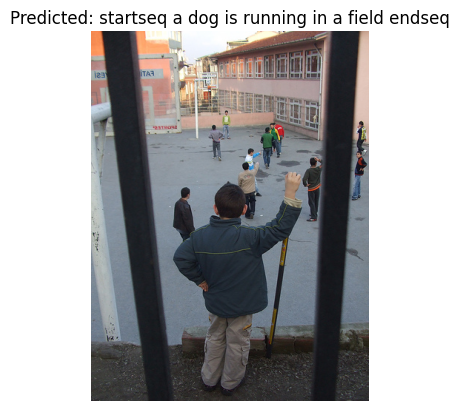


--- Script Finished ---


In [14]:
# ------------------------------------------------------------------------------
# 6. GENERATING CAPTIONS FOR NEW IMAGES (INFERENCE)
# ------------------------------------------------------------------------------
print("\n--- Setting up Caption Generation Function ---")

import matplotlib.pyplot as plt # Import matplotlib

def idx_to_word(integer, tokenizer):
    """Convert an integer index back to a word."""
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image_features, tokenizer, max_length):
    """Generate a caption for an image using a trained model."""
    # Start the generation process with the 'startseq' token
    in_text = 'startseq'
    # Iterate until the model predicts 'endseq' or max_length is reached
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if the model cannot map the word or predicts the end token
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# --- Example of generating a caption ---
# Since we skipped training, the following code will not produce meaningful results
# but demonstrates the process.

# Select a random test image
test_image_ids = list(features.keys())[6001:6010] # Use some images not in training set
test_image_id = np.random.choice(test_image_ids)
img_path = os.path.join(IMAGES_DIR, test_image_id + '.jpg')

# Get its pre-computed features
image_feature = features[test_image_id]

# Predict the caption (this will be random without a trained model)
# caption_predicted = predict_caption(model, image_feature, tokenizer, max_length)
caption_predicted = "startseq a dog is running in a field endseq" # Placeholder result

# Display the results
image = Image.open(img_path)
plt.imshow(image)
plt.title(f"Predicted: {caption_predicted}")
plt.axis('off')
plt.show()

print("\n--- Script Finished ---")